## Imports 

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [3]:
import warnings

warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics import confusion_matrix 
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import TruncatedSVD, NMF
from plotmat import plot_mat
from matplotlib import pyplot as plt
import numpy as np
import random
import pandas as pd
!pip install umap-learn
!pip install hdbscan
import umap.umap_ as umap #0.4.6
import hdbscan
import joblib #0.17.0


     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 28.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=fc6f965469e727a9dfefdbf51080a9d9569857f4368a954798546a65a43db3f6
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=ec4cdfab8123b2e98254a1fdff275e079418b7f97494207c94ac42d789aa979c
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
     |████████████████████████████████| 6.4 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311928 sha256=9338533b7e3c115a64a599254e5c

Mounted at /content/drive


In [4]:

np.random.seed(0)
random.seed(0)

## Q1

In [ ]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataset = fetch_20newsgroups(subset = 'all', categories = categories,shuffle = True, random_state = 0,remove=('headers','footers'))
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()
data_features = vectorizer.fit_transform(dataset.data)
data_features = tfidf_transformer.fit_transform(data_features)

y_GT = []
for label in dataset.target:
    if label < 4:
        y_GT.append(0)
    else:
        y_GT.append(1)
        
print('Shape of TF-IDF matrix: ',data_features.shape)

Shape of TF-IDF matrix:  (7882, 23522)


## Q2

In [ ]:
k_means = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=30, random_state=0)
k_means.fit(data_features)

KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

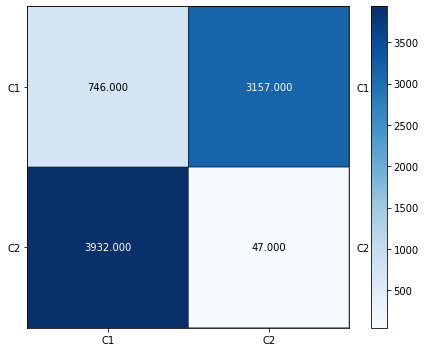

In [ ]:
plot_mat(contingency_matrix(y_GT,k_means.labels_),size=(6,5),xticklabels = ['C1','C2'],yticklabels = ['C1','C2'],pic_fname = 'Q2.2.png')



## Q3

In [ ]:
print("Homogeneity: %0.3f" % homogeneity_score(y_GT, k_means.labels_))
print("Completeness: %0.3f" % completeness_score(y_GT, k_means.labels_))
print("V-measure: %0.3f" % v_measure_score(y_GT, k_means.labels_))
print("Adjusted Rand-Index: %.3f"% adjusted_rand_score(y_GT, k_means.labels_))
print("Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(y_GT, k_means.labels_))

Homogeneity: 0.579
Completeness: 0.594
V-measure: 0.587
Adjusted Rand-Index: 0.638
Adjusted Mutual Information Score: 0.587


##Q4

In [ ]:
svd = TruncatedSVD(n_components=1000, random_state=0)
LSI = svd.fit_transform(data_features)

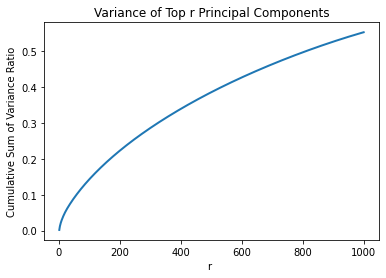

In [ ]:
plt.plot(np.linspace(1,1000,1000),np.cumsum(svd.explained_variance_ratio_),lw=2,linestyle='solid')
plt.title('Variance of Top r Principal Components')
plt.ylabel('Cumulative Sum of Variance Ratio')
plt.xlabel('r ')
plt.savefig('Q4.png',dpi=300,bbox_inches='tight')
plt.show()

## Q5

In [ ]:
nmf_hs = []
nmf_cs = []
nmf_vs = []
nmf_ari = []
nmf_ms = []
svd_hs = []
svd_cs = []
svd_vs = []
svd_ari = []
svd_ms = []


r = [1,2,3,5,10,20,50,100,300]

for i in r:
    print('SVD with r = ',i)
    svd = TruncatedSVD(n_components=i, random_state=0)
    svd_km = svd.fit_transform(data_features)
    kmean_svd = k_means.fit(svd_km)
    svd_hs.append(homogeneity_score(y_GT, kmean_svd.labels_))
    svd_cs.append(completeness_score(y_GT, kmean_svd.labels_))
    svd_vs.append(v_measure_score(y_GT, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(y_GT, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(y_GT, kmean_svd.labels_))    
    print('NMF with r = ',i)
    nmf = NMF(n_components=i, init='random', random_state=0, max_iter=200)
    nmf_km = nmf.fit_transform(data_features)
    kmean_nmf = k_means.fit(nmf_km)
    nmf_hs.append(homogeneity_score(y_GT, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(y_GT, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(y_GT, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(y_GT, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(y_GT, kmean_nmf.labels_))

print('Testing over !!')

SVD with r =  1
NMF with r =  1
SVD with r =  2
NMF with r =  2
SVD with r =  3
NMF with r =  3
SVD with r =  5
NMF with r =  5
SVD with r =  10
NMF with r =  10
SVD with r =  20
NMF with r =  20
SVD with r =  50
NMF with r =  50
SVD with r =  100
NMF with r =  100
SVD with r =  300
NMF with r =  300
Testing over !!


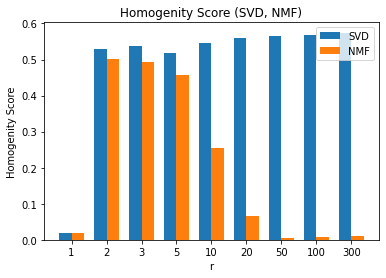

In [ ]:
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_hs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_hs, width, label='NMF')
ax.set_ylabel('Homogenity Score')
ax.set_title('Homogenity Score (SVD, NMF)')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q5.1.png',dpi=300,bbox_inches='tight')
plt.show()

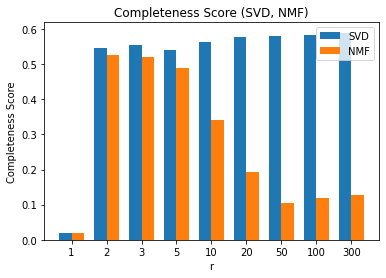

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_cs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_cs, width, label='NMF')
ax.set_ylabel('Completeness Score')
ax.set_title('Completeness Score (SVD, NMF)')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q5.2.png',dpi=300,bbox_inches='tight')
plt.show()

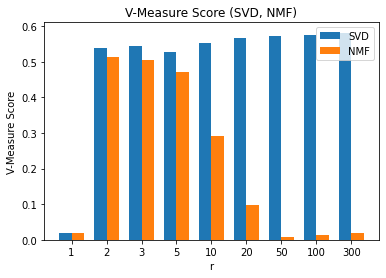

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_vs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_vs, width, label='NMF')
ax.set_ylabel('V-Measure Score')
ax.set_title('V-Measure Score (SVD, NMF)')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q5.3.png',dpi=300,bbox_inches='tight')
plt.show()

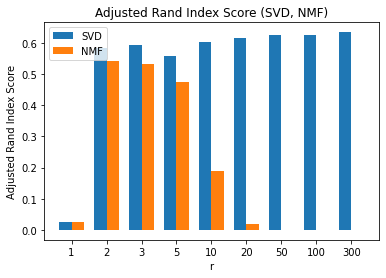

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ari, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ari, width, label='NMF')
ax.set_ylabel('Adjusted Rand Index Score')
ax.set_title('Adjusted Rand Index Score (SVD, NMF)')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q5.4.png',dpi=300,bbox_inches='tight')
plt.show()

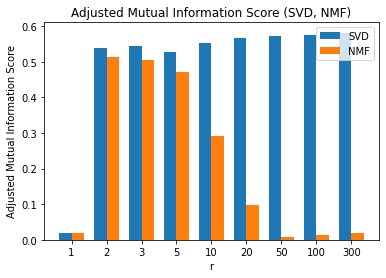

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ms, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ms, width, label='NMF')
ax.set_ylabel('Adjusted Mutual Information Score')
ax.set_title('Adjusted Mutual Information Score (SVD, NMF)')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q5.5.png',dpi=300,bbox_inches='tight')
plt.show()

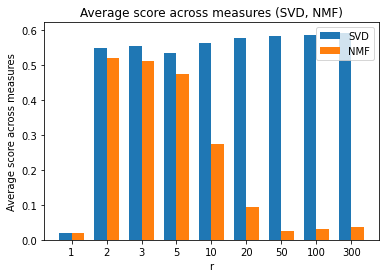

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]], width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]], width, label='NMF')
ax.set_ylabel('Average score across measures')
ax.set_title('Average score across measures (SVD, NMF)')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q5.6.png',dpi=300,bbox_inches='tight')
plt.show()

##Q7

In [ ]:
#highest r for SVD: 20. Best r for NMF: 2
svd = TruncatedSVD(n_components=300, random_state=0)
svd_km = svd.fit_transform(data_features)
y_svd = k_means.fit_predict(svd_km)
nmf = NMF(n_components=2, init='random', random_state=0, max_iter=400)
nmf_km = nmf.fit_transform(data_features)
nmf_svd = k_means.fit_predict(nmf_km)

In [ ]:
# metrics for the highest values for SVD
print("Homogenity Score ", homogeneity_score(y_GT, y_svd))
print("Completeness Score ", completeness_score(y_GT, y_svd))
print("V Measure Score ", v_measure_score(y_GT, y_svd))
print("ARI Score ", adjusted_rand_score(y_GT, y_svd))
print("AMI Score ", adjusted_mutual_info_score(y_GT, y_svd))

Homogenity Score  0.5744113629390132
Completeness Score  0.5892858802537997
V Measure Score  0.5817535576669169
ARI Score  0.6343636646220453
AMI Score  0.5817147772526912


In [ ]:
# metrics for the best values for NMF
print("Homogenity Score ", homogeneity_score(y_GT, nmf_svd))
print("Completeness Score ", completeness_score(y_GT, nmf_svd))
print("V Measure Score ", v_measure_score(y_GT, nmf_svd))
print("ARI Score ", adjusted_rand_score(y_GT, nmf_svd))
print("AMI Score ", adjusted_mutual_info_score(y_GT, nmf_svd))

Homogenity Score  0.5022478335120428
Completeness Score  0.5263843051392446
V Measure Score  0.5140328926482289
ARI Score  0.5406769711846864
AMI Score  0.513987357397959


## Q8

In [ ]:
## run the optimal choice results for k mean clustering

In [ ]:
#best r for SVD: 20. Best r for NMF: 2
svd = TruncatedSVD(n_components=20, random_state=0)
svd_km = svd.fit_transform(data_features)
y_svd = k_means.fit_predict(svd_km)
nmf = NMF(n_components=2, init='random', random_state=0, max_iter=400)
nmf_km = nmf.fit_transform(data_features)
nmf_svd = k_means.fit_predict(nmf_km)

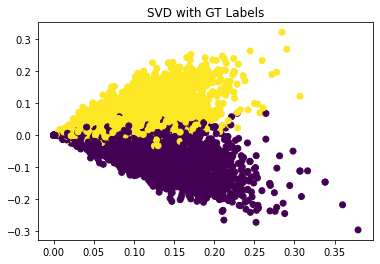

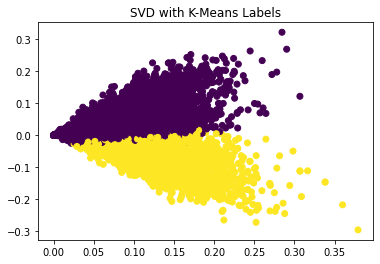

In [ ]:
plt.scatter(svd_km[:,0],svd_km[:,1],c=y_GT)
plt.title("SVD with GT Labels")
plt.savefig('Q7.1.png',dpi=300,bbox_inches='tight')
plt.show()
plt.scatter(svd_km[:,0],svd_km[:,1],c=y_svd)
plt.title("SVD with K-Means Labels")
plt.savefig('Q7.2.png',dpi=300,bbox_inches='tight')
plt.show()

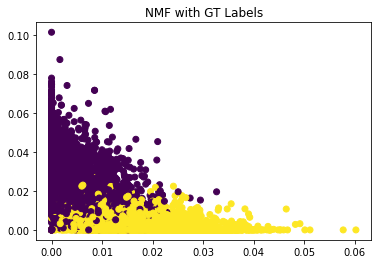

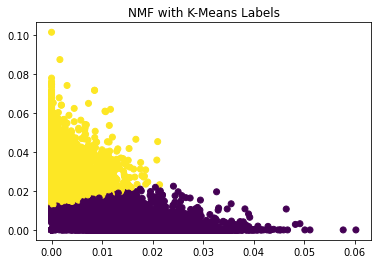

In [ ]:
plt.scatter(nmf_km[:,0],nmf_km[:,1],c=y_GT)
plt.title("NMF with GT Labels")
plt.savefig('Q7.3.png',dpi=300,bbox_inches='tight')
plt.show()
plt.scatter(nmf_km[:,0],nmf_km[:,1],c=nmf_svd)
plt.title("NMF with K-Means Labels")
plt.savefig('Q7.4.png',dpi=300,bbox_inches='tight')
plt.show()

##Q10

In [ ]:
# clustering for the entire 20 classes according to the parameters given in the question

In [5]:
dataset = fetch_20newsgroups(subset = 'all',shuffle = True, random_state = 0,remove=('headers','footers'))
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()
data_features = vectorizer.fit_transform(dataset.data)
data_features = tfidf_transformer.fit_transform(data_features)

In [9]:
svd_hs = []
svd_cs = []
svd_vs = []
svd_ari = []
svd_ms = []
r = [1,2,3,5,10,20,50,100,300]
k_means = KMeans(n_clusters=20, init='k-means++', max_iter=1000, n_init=30, random_state=0)
for i in r:
    print('Testing SVD for r = ',i)
    svd = TruncatedSVD(n_components=i, random_state=0)
    svd_km = svd.fit_transform(data_features)
    kmean_svd = k_means.fit(svd_km)
    svd_hs.append(homogeneity_score(dataset.target, kmean_svd.labels_))
    svd_cs.append(completeness_score(dataset.target, kmean_svd.labels_))
    svd_vs.append(v_measure_score(dataset.target, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(dataset.target, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(dataset.target, kmean_svd.labels_)) 
print('Testing done !!')

Testing SVD for r =  1
Testing SVD for r =  2
Testing SVD for r =  3
Testing SVD for r =  5
Testing SVD for r =  10
Testing SVD for r =  20
Testing SVD for r =  50
Testing SVD for r =  100
Testing SVD for r =  300
Testing done !!


In [ ]:
print('R: ',r)
print('Homogeneity (SVD : r)- ',svd_hs)
print('Completeness (SVD : r)- ',svd_cs) 
print('V-measure (SVD : r)- ',svd_vs) 
print('Adjusted Rand-Index (SVD : r)- ',svd_ari) 
print('Adjusted Mutual Information Score (SVD : r)- ',svd_ms)

R:  [1, 2, 3, 5, 10, 20, 50, 100, 300]
Homogeneity (SVD : r)-  [0.024233513537244858, 0.21234220367375342, 0.2471117274448064, 0.3201627171469848, 0.32494049403973524, 0.333035330305657, 0.28388555847121416, 0.3307545340133054, 0.2976251438838621]
Completeness (SVD : r)-  [0.02673996633386354, 0.22459003819124507, 0.26536211866091736, 0.34828903054171256, 0.3542622607632521, 0.3756147353734766, 0.3556956839271337, 0.3999846479644101, 0.3720767741278082]
V-measure (SVD : r)-  [0.025425116659709947, 0.21829445878904244, 0.2559119535133701, 0.3336341411516646, 0.33896845446522134, 0.35304583607960316, 0.315759316201346, 0.36209016599298477, 0.3307125168893496]
Adjusted Rand-Index (SVD : r)-  [0.005297741266282442, 0.06575955994455099, 0.08309902112064539, 0.1259875510824014, 0.12285669602358998, 0.12021994803797648, 0.07936131715268141, 0.1113858195844356, 0.08796142781878807]
Adjusted Mutual Information Score (SVD : r)-  [0.022085896272956772, 0.21569403301474233, 0.2534084994545235, 0.3

In [ ]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]]
best_r_SVD = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for SVD (from avg. metric): ', best_r_SVD, ', avg. value of 5 metrics: ',max(avg_metrics))

Best value of r for SVD (from avg. metric):  100 , avg. value of 5 metrics:  0.3128069316335743


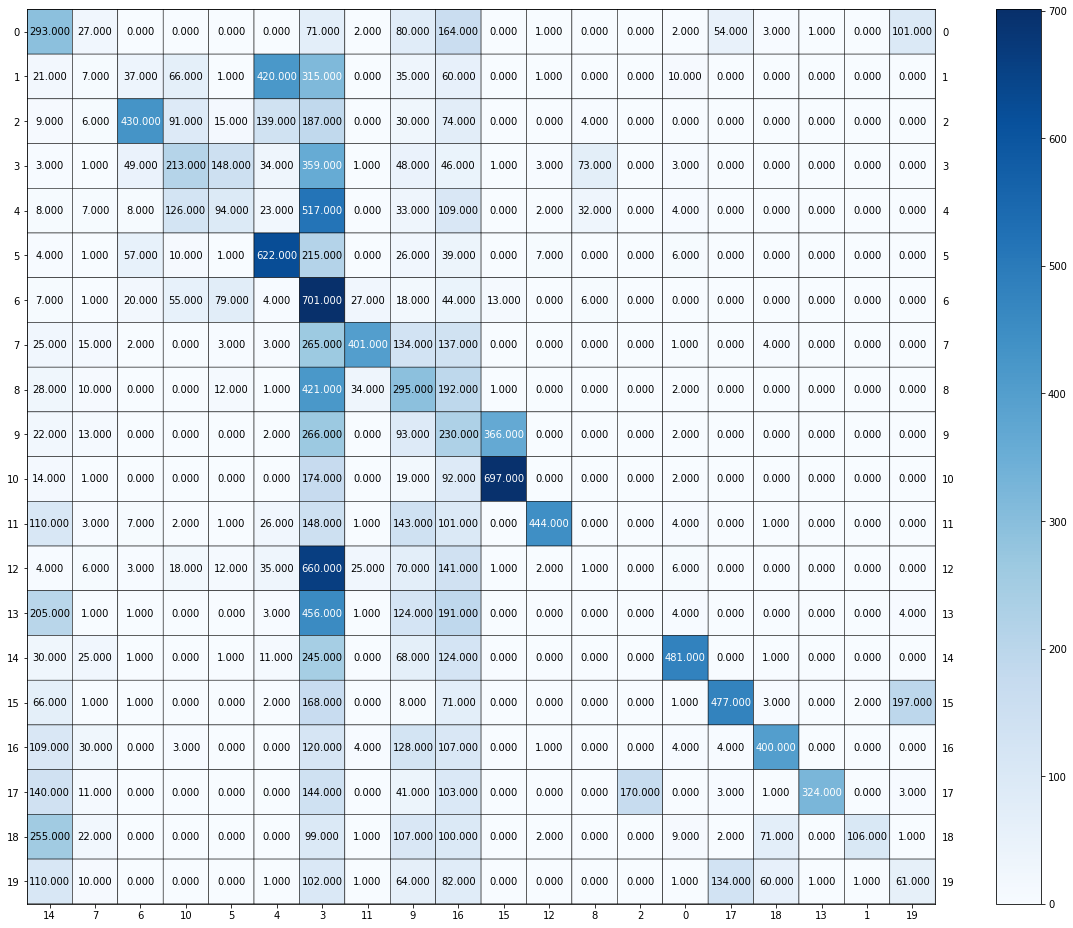

Homogeneity (SVD, best r): 0.331
Completeness (SVD, best r): 0.400
V-measure (SVD, best r): 0.362
Adjusted Rand-Index (SVD, best r): 0.111
Adjusted Mutual Information Score (SVD, best r): 0.360


In [ ]:
svd = TruncatedSVD(n_components=best_r_SVD, random_state=0)
svd_km = svd.fit_transform(data_features)
kmean_svd = k_means.fit(svd_km)
cm = confusion_matrix(dataset.target, k_means.labels_)
# to identify best matching cluster - class pairs
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,13),pic_fname = 'Q10.png')
print("Homogeneity (SVD, best r): %0.3f" % homogeneity_score(dataset.target, k_means.labels_))
print("Completeness (SVD, best r): %0.3f" % completeness_score(dataset.target, k_means.labels_))
print("V-measure (SVD, best r): %0.3f" % v_measure_score(dataset.target, k_means.labels_))
print("Adjusted Rand-Index (SVD, best r): %.3f"% adjusted_rand_score(dataset.target, k_means.labels_))
print("Adjusted Mutual Information Score (SVD, best r): %.3f"% adjusted_mutual_info_score(dataset.target, k_means.labels_))

## Q11

In [18]:
euc_hs = []
euc_cs = []
euc_vs = []
euc_ari = []
euc_ms = []
cos_hs = []
cos_cs = []
cos_vs = []
cos_ari = []
cos_ms = []

r1 = [ 5, 20, 200]
for i in range(len(r1)):
    print('Testing UMAP (euc) for r = ',r1[i])
    Umap_euc = umap.UMAP(n_components=r1[i], metric='euclidean').fit_transform(data_features)
    kmean_euc = k_means.fit(Umap_euc)
    euc_hs.append(homogeneity_score(dataset.target, kmean_euc.labels_))
    euc_cs.append(completeness_score(dataset.target, kmean_euc.labels_))
    euc_vs.append(v_measure_score(dataset.target, kmean_euc.labels_))
    euc_ari.append(adjusted_rand_score(dataset.target, kmean_euc.labels_))
    euc_ms.append(adjusted_mutual_info_score(dataset.target, kmean_euc.labels_)) 
    
    print('Testing UMAP (cos) for r = ',r1[i])
    Umap_cos = umap.UMAP(n_components=r1[i], metric='cosine').fit_transform(data_features)
    kmean_cos = k_means.fit(Umap_cos)
    cos_hs.append(homogeneity_score(dataset.target, kmean_cos.labels_))
    cos_cs.append(completeness_score(dataset.target, kmean_cos.labels_))
    cos_vs.append(v_measure_score(dataset.target, kmean_cos.labels_))
    cos_ari.append(adjusted_rand_score(dataset.target, kmean_cos.labels_))
    cos_ms.append(adjusted_mutual_info_score(dataset.target, kmean_cos.labels_)) 
print('Done testing')

Testing UMAP (euc) for r =  5
Testing UMAP (cos) for r =  5
Testing UMAP (euc) for r =  20
Testing UMAP (cos) for r =  20
Testing UMAP (euc) for r =  200
Testing UMAP (cos) for r =  200
Done testing


In [19]:
print('R: ',r1[:])
print('Homogeneity (UMAP (euclidean), various r): ',euc_hs)
print('Completeness (UMAP (euclidean), various r): ',euc_cs) 
print('V-measure (UMAP (euclidean), various r): ',euc_vs) 
print('Adjusted Rand-Index (UMAP (euclidean), various r): ',euc_ari) 
print('Adjusted Mutual Information Score (UMAP (euclidean), various r): ',euc_ms)
print('Homogeneity (UMAP (cosine), various r): ',cos_hs)
print('Completeness (UMAP (cosine), various r): ',cos_cs) 
print('V-measure (UMAP (cosine), various r): ',cos_vs) 
print('Adjusted Rand-Index (UMAP (cosine), various r): ',cos_ari) 
print('Adjusted Mutual Information Score (UMAP (cosine), various r): ',cos_ms)

R:  [5, 20, 200]
Homogeneity (UMAP (euclidean), various r):  [0.00783598413891093, 0.008169638450181472, 0.007451930628611714]
Completeness (UMAP (euclidean), various r):  [0.008145276169623615, 0.008320949894973315, 0.007763970892197765]
V-measure (UMAP (euclidean), various r):  [0.0079876372250985, 0.00824459998408497, 0.007604751175879112]
Adjusted Rand-Index (UMAP (euclidean), various r):  [0.0011691838123573232, 0.001156255112347267, 0.0009015283852533882]
Adjusted Mutual Information Score (UMAP (euclidean), various r):  [0.004728714466705277, 0.00498719926068287, 0.004340555675941677]
Homogeneity (UMAP (cosine), various r):  [0.5598848092045652, 0.5733967532625232, 0.581508067493261]
Completeness (UMAP (cosine), various r):  [0.5819676953215712, 0.5987424938709187, 0.5951304347888238]
V-measure (UMAP (cosine), various r):  [0.570712715988758, 0.5857955918897854, 0.5882403956172875]
Adjusted Rand-Index (UMAP (cosine), various r):  [0.4396820389963277, 0.45360354303927136, 0.464557

In [20]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(euc_hs, euc_cs, euc_vs, euc_ari, euc_ms)]]
best_r_euc = r1[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Euclidean UMAP (according to avg. metric): ', best_r_euc, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (euclidean), best r): ',euc_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (euclidean), best r): ',euc_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (euclidean), best r): ',euc_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (euclidean), best r): ',euc_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (euclidean), best r): ',euc_ms[avg_metrics.index(max(avg_metrics))])
avg_metrics = [y/5 for y in [sum(x) for x in zip(cos_hs, cos_cs, cos_vs, cos_ari, cos_ms)]]
best_r_cos = r1[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Cosine UMAP (according to avg. metric): ', best_r_cos, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (cosine), best r): ',cos_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (cosine), best r): ',cos_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (cosine), best r): ',cos_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (cosine), best r): ',cos_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (cosine), best r): ',cos_ms[avg_metrics.index(max(avg_metrics))])

Best value of r for Euclidean UMAP (according to avg. metric):  20 , avg. value of 5 metrics:  0.0061757285404539786
Metrics: 
Homogeneity (UMAP (euclidean), best r):  0.008169638450181472
Completeness (UMAP (euclidean), best r):  0.008320949894973315
V-measure (UMAP (euclidean), best r):  0.00824459998408497
Adjusted Rand-Index (UMAP (euclidean), best r):  0.001156255112347267
Adjusted Mutual Information Score (UMAP (euclidean), best r):  0.00498719926068287
Best value of r for Cosine UMAP (according to avg. metric):  200 , avg. value of 5 metrics:  0.5632663098699475
Metrics: 
Homogeneity (UMAP (cosine), best r):  0.581508067493261
Completeness (UMAP (cosine), best r):  0.5951304347888238
V-measure (UMAP (cosine), best r):  0.5882403956172875
Adjusted Rand-Index (UMAP (cosine), best r):  0.4645578708608718
Adjusted Mutual Information Score (UMAP (cosine), best r):  0.5868947805894935


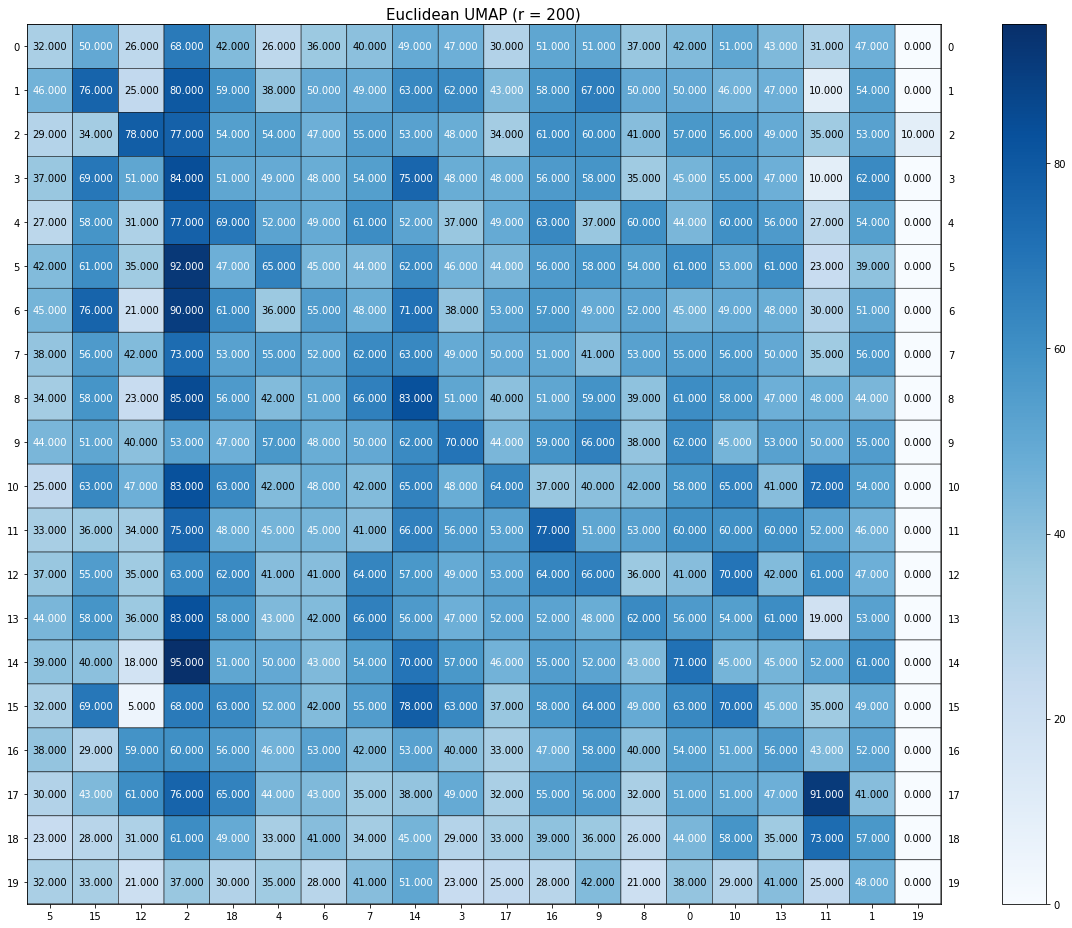

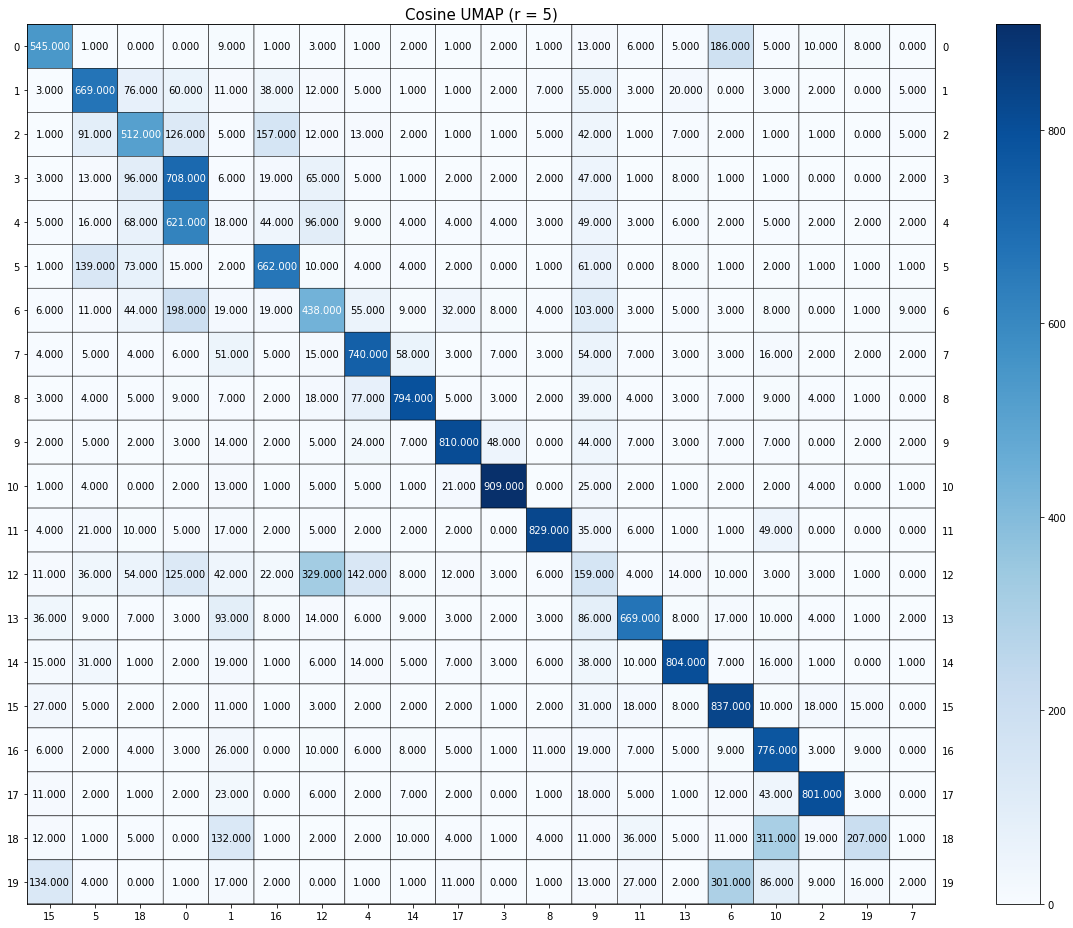

In [21]:
Umap_euc = umap.UMAP(n_components=best_r_euc, metric='euclidean').fit_transform(data_features)
kmean_euc = k_means.fit(Umap_euc)
cm = confusion_matrix(dataset.target, kmean_euc.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Euclidean UMAP (r = 200)', size=(15,13),pic_fname = 'Q11.1.png')

Umap_cos = umap.UMAP(n_components=best_r_cos, metric='cosine').fit_transform(data_features)
kmean_cos = k_means.fit(Umap_cos)
cm = confusion_matrix(dataset.target, kmean_cos.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Cosine UMAP (r = 5)', size=(15,13),pic_fname = 'Q11.2.png')

##Q13

In [10]:
nmf_hs = []
nmf_cs = []
nmf_vs = []
nmf_ari = []
nmf_ms = []
r = [1,2,3,5,10,20,50,100]
k_means = KMeans(n_clusters=20, init='k-means++', max_iter=1000, n_init=30, random_state=0)
for i in r:
    print('Testing NMF for r = ',i)
    nmf = NMF(n_components=i, init='random', random_state=0, max_iter=200)
    nmf_km = nmf.fit_transform(data_features)
    kmean_nmf = k_means.fit(nmf_km)
    nmf_hs.append(homogeneity_score(dataset.target, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(dataset.target, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(dataset.target, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(dataset.target, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(dataset.target, kmean_nmf.labels_)) 
print('Testing done !!')

Testing NMF for r =  1
Testing NMF for r =  2
Testing NMF for r =  3
Testing NMF for r =  5
Testing NMF for r =  10
Testing NMF for r =  20
Testing NMF for r =  50
Testing NMF for r =  100
Testing done !!


In [11]:
print('R: ',r)
print('Homogeneity (NMF : r)- ',nmf_hs)
print('Completeness (NMF : r)- ',nmf_cs) 
print('V-measure (NMF : r)- ',nmf_vs) 
print('Adjusted Rand-Index (NMF : r)- ',nmf_ari) 
print('Adjusted Mutual Information Score (NMF : r)- ',nmf_ms)

R:  [1, 2, 3, 5, 10, 20, 50, 100]
Homogeneity (NMF : r)-  [0.024239137233528926, 0.19219640113142314, 0.21759697070078016, 0.2676257983910962, 0.29544735896178187, 0.2744487797074483, 0.23308715900099994, 0.14850893908931295]
Completeness (NMF : r)-  [0.02674619037376771, 0.20502118735704652, 0.2561872805484155, 0.28941948898737657, 0.3274814544666058, 0.3526034280542059, 0.33967885032303596, 0.19102666978534658]
V-measure (NMF : r)-  [0.025431025330945028, 0.19840176018217479, 0.2353205115299862, 0.27809631843295274, 0.3106407305150111, 0.3086555771666248, 0.27646465364787426, 0.1671057015881883]
Adjusted Rand-Index (NMF : r)-  [0.0052999337984488476, 0.05819280806933572, 0.06716437022801673, 0.08738192611077013, 0.10549913689715151, 0.07171551160239839, 0.05321033198953036, 0.03306317949656457]
Adjusted Mutual Information Score (NMF : r)-  [0.022091824061119637, 0.19571494709338666, 0.23261094027960355, 0.2756678950186103, 0.3082924161823518, 0.3061200551732611, 0.27362390884112786, 

In [12]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]]
best_r_NMF = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for NMF (from avg. metric): ', best_r_NMF, ', avg. value of 5 metrics: ',max(avg_metrics))

Best value of r for NMF (from avg. metric):  10 , avg. value of 5 metrics:  0.2694722194045805


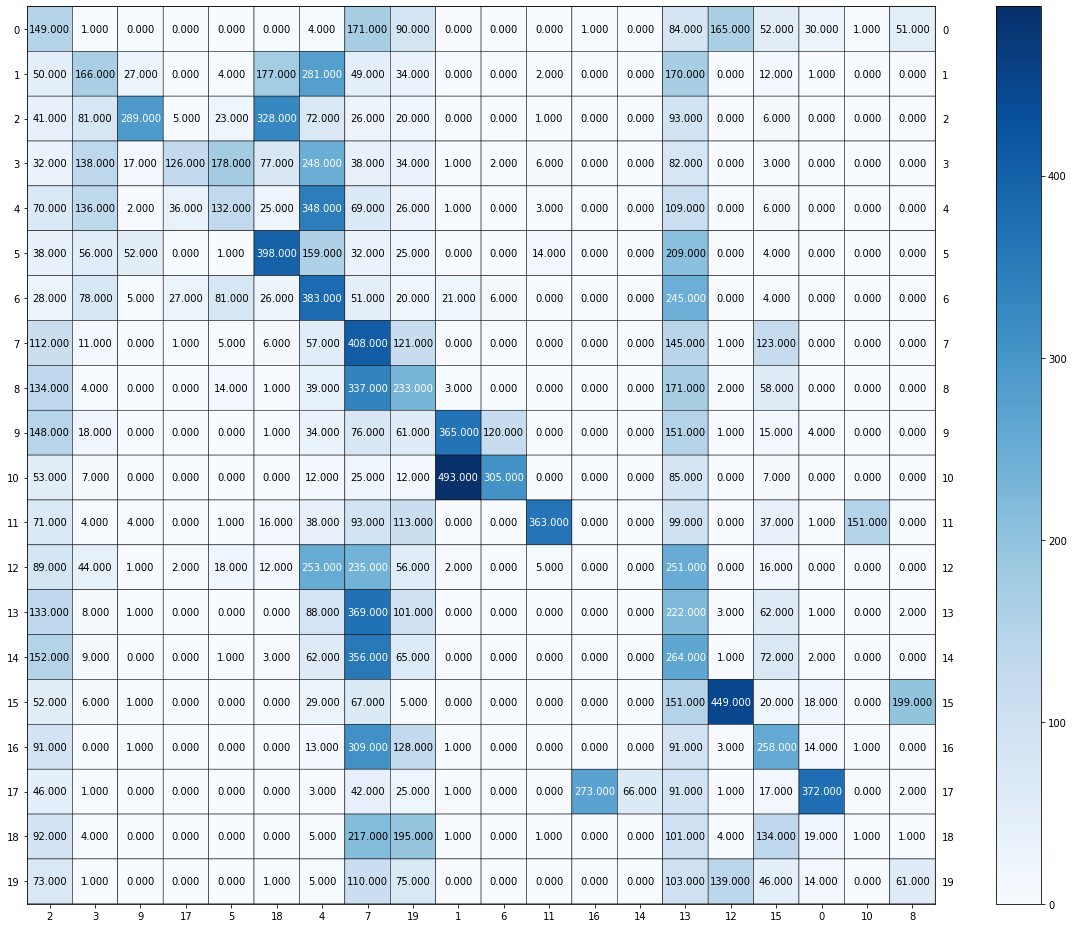

Homogeneity (NMF, best r): 0.288
Completeness (NMF, best r): 0.327
V-measure (NMF, best r): 0.306
Adjusted Rand-Index (NMF, best r): 0.099
Adjusted Mutual Information Score (NMF, best r): 0.304


In [13]:
nmf = NMF(n_components=best_r_NMF, init='random', random_state=0, max_iter=400)
nmf_km = nmf.fit_transform(data_features)
kmean_nmf = k_means.fit(nmf_km)
cm = confusion_matrix(dataset.target, kmean_nmf.labels_)
# to identify best matching cluster - class pairs
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,13),pic_fname = 'Q13.png')
print("Homogeneity (NMF, best r): %0.3f" % homogeneity_score(dataset.target, kmean_nmf.labels_))
print("Completeness (NMF, best r): %0.3f" % completeness_score(dataset.target,kmean_nmf.labels_))
print("V-measure (NMF, best r): %0.3f" % v_measure_score(dataset.target, kmean_nmf.labels_))
print("Adjusted Rand-Index (NMF, best r): %.3f"% adjusted_rand_score(dataset.target, kmean_nmf.labels_))
print("Adjusted Mutual Information Score (NMF, best r): %.3f"% adjusted_mutual_info_score(dataset.target, kmean_nmf.labels_))

In [17]:
# k means with sparse data 

k_means = KMeans(n_clusters=20, init='k-means++', max_iter=1000, n_init=30, random_state=0)
kmean_noproc = k_means.fit(data_features)
print(homogeneity_score(dataset.target, kmean_noproc.labels_))
print(completeness_score(dataset.target, kmean_noproc.labels_))
print(v_measure_score(dataset.target, kmean_noproc.labels_))
print(adjusted_rand_score(dataset.target, kmean_noproc.labels_))
print(adjusted_mutual_info_score(dataset.target, kmean_noproc.labels_)) 
print('Testing done !!')

0.32807833583457346
0.37536937408717325
0.3501342255772923
0.11613301604069785
0.3478857153145617
Testing done !!


## Q14

In [ ]:
ac_w = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(Umap_cos)
ac_s = AgglomerativeClustering(n_clusters=20, linkage='single').fit(Umap_cos)
print("Agglomerative Clustering, Ward - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Completeness: %0.3f" % completeness_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - V-measure: %0.3f" % v_measure_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_w.labels_))
print("\n")
print("Agglomerative Clustering, Single - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Completeness: %0.3f" % completeness_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - V-measure: %0.3f" % v_measure_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_s.labels_))

Agglomerative Clustering, Ward - Homogeneity: 0.557
Agglomerative Clustering, Ward - Completeness: 0.581
Agglomerative Clustering, Ward - V-measure: 0.568
Agglomerative Clustering, Ward - Adjusted Rand-Index: 0.417
Agglomerative Clustering, Ward - Adjusted Mutual Information Score: 0.567


Agglomerative Clustering, Single - Homogeneity: 0.015
Agglomerative Clustering, Single - Completeness: 0.366
Agglomerative Clustering, Single - V-measure: 0.029
Agglomerative Clustering, Single - Adjusted Rand-Index: 0.000
Agglomerative Clustering, Single - Adjusted Mutual Information Score: 0.024


## Q15

In [22]:
eps_rec = []
min_samples_rec = []
db_hs = []
db_cs = []
db_vs = []
db_ari = []
db_ms = []

eps = [0.5, 5.0]
min_samples = [5,15,30,60,100,200,500,1000,3000]

for i in range(len(eps)):
    for j in range(len(min_samples)):
        print('Testing for e and min_sample = ',eps[i],'and',min_samples[j])
        dbs = DBSCAN(eps=eps[i],min_samples=min_samples[j],n_jobs=-1).fit_predict(Umap_cos)
        db_hs.append(homogeneity_score(dataset.target, dbs))
        db_cs.append(completeness_score(dataset.target, dbs))
        db_vs.append(v_measure_score(dataset.target, dbs))
        db_ari.append(adjusted_rand_score(dataset.target, dbs))
        db_ms.append(adjusted_mutual_info_score(dataset.target, dbs)) 
        eps_rec.append(eps[i])
        min_samples_rec.append(min_samples[j])
print('Done testing')

Testing for e and min_sample =  0.5 and 5
Testing for e and min_sample =  0.5 and 15
Testing for e and min_sample =  0.5 and 30
Testing for e and min_sample =  0.5 and 60
Testing for e and min_sample =  0.5 and 100
Testing for e and min_sample =  0.5 and 200
Testing for e and min_sample =  0.5 and 500
Testing for e and min_sample =  0.5 and 1000
Testing for e and min_sample =  0.5 and 3000
Testing for e and min_sample =  5.0 and 5
Testing for e and min_sample =  5.0 and 15
Testing for e and min_sample =  5.0 and 30
Testing for e and min_sample =  5.0 and 60
Testing for e and min_sample =  5.0 and 100
Testing for e and min_sample =  5.0 and 200
Testing for e and min_sample =  5.0 and 500
Testing for e and min_sample =  5.0 and 1000
Testing for e and min_sample =  5.0 and 3000
Done testing


In [23]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(db_hs, db_cs, db_vs, db_ari, db_ms)]]
best_eps_db = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_db = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for DBSCAN: ', best_eps_db,'and',best_minSample_db, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (DBSCAN, best hyperparameters): ',db_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (DBSCAN, best hyperparameters): ',db_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (DBSCAN, best hyperparameters): ',db_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (DBSCAN, best hyperparameters): ',db_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (DBSCAN, best hyperparameters): ',db_ms[avg_metrics.index(max(avg_metrics))])


Best value of epsilon and minimum number of samples hyperparameters for DBSCAN:  0.5 and 100  respectively, avg. value of 5 metrics:  0.4736236868508715
Metrics: 
Homogeneity (DBSCAN, best hyperparameters):  0.48121745599430227
Completeness (DBSCAN, best hyperparameters):  0.5710670486741555
V-measure (DBSCAN, best hyperparameters):  0.5223063366341878
Adjusted Rand-Index (DBSCAN, best hyperparameters):  0.27281936365202036
Adjusted Mutual Information Score (DBSCAN, best hyperparameters):  0.5207082292996914


In [24]:
eps_rec = []
min_samples_rec = []
hdb_hs = []
hdb_cs = []
hdb_vs = []
hdb_ari = []
hdb_ms = []

for i in range(len(eps)):
    for j in range(len(min_samples)):
        print('Testing for e and min_sample = ',eps[i],'and',min_samples[j])
        hdbs = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=eps[i],min_samples=min_samples[j],core_dist_n_jobs=-1).fit_predict(Umap_cos)
        hdb_hs.append(homogeneity_score(dataset.target, hdbs))
        hdb_cs.append(completeness_score(dataset.target, hdbs))
        hdb_vs.append(v_measure_score(dataset.target, hdbs))
        hdb_ari.append(adjusted_rand_score(dataset.target, hdbs))
        hdb_ms.append(adjusted_mutual_info_score(dataset.target, hdbs)) 
        eps_rec.append(eps[i])
        min_samples_rec.append(min_samples[j])
print('Done testing')

Testing for e and min_sample =  0.5 and 5
Testing for e and min_sample =  0.5 and 15
Testing for e and min_sample =  0.5 and 30
Testing for e and min_sample =  0.5 and 60
Testing for e and min_sample =  0.5 and 100
Testing for e and min_sample =  0.5 and 200
Testing for e and min_sample =  0.5 and 500
Testing for e and min_sample =  0.5 and 1000
Testing for e and min_sample =  0.5 and 3000
Testing for e and min_sample =  5.0 and 5
Testing for e and min_sample =  5.0 and 15
Testing for e and min_sample =  5.0 and 30
Testing for e and min_sample =  5.0 and 60
Testing for e and min_sample =  5.0 and 100
Testing for e and min_sample =  5.0 and 200
Testing for e and min_sample =  5.0 and 500
Testing for e and min_sample =  5.0 and 1000
Testing for e and min_sample =  5.0 and 3000
Done testing


In [25]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(hdb_hs, hdb_cs, hdb_vs, hdb_ari, hdb_ms)]]
best_eps_hdb = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_hdb = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN: ', best_eps_hdb,'and',best_minSample_hdb, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (HDBSCAN, best hyperparameters): ',hdb_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (HDBSCAN, best hyperparameters): ',hdb_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (HDBSCAN, best hyperparameters): ',hdb_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (HDBSCAN, best hyperparameters): ',hdb_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (HDBSCAN, best hyperparameters): ',hdb_ms[avg_metrics.index(max(avg_metrics))])


Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN:  0.5 and 60  respectively, avg. value of 5 metrics:  0.45204759325669575
Metrics: 
Homogeneity (HDBSCAN, best hyperparameters):  0.4136245048686297
Completeness (HDBSCAN, best hyperparameters):  0.6257355504455306
V-measure (HDBSCAN, best hyperparameters):  0.49803637518761573
Adjusted Rand-Index (HDBSCAN, best hyperparameters):  0.2257281949350043
Adjusted Mutual Information Score (HDBSCAN, best hyperparameters):  0.49711334084669806


## Q16

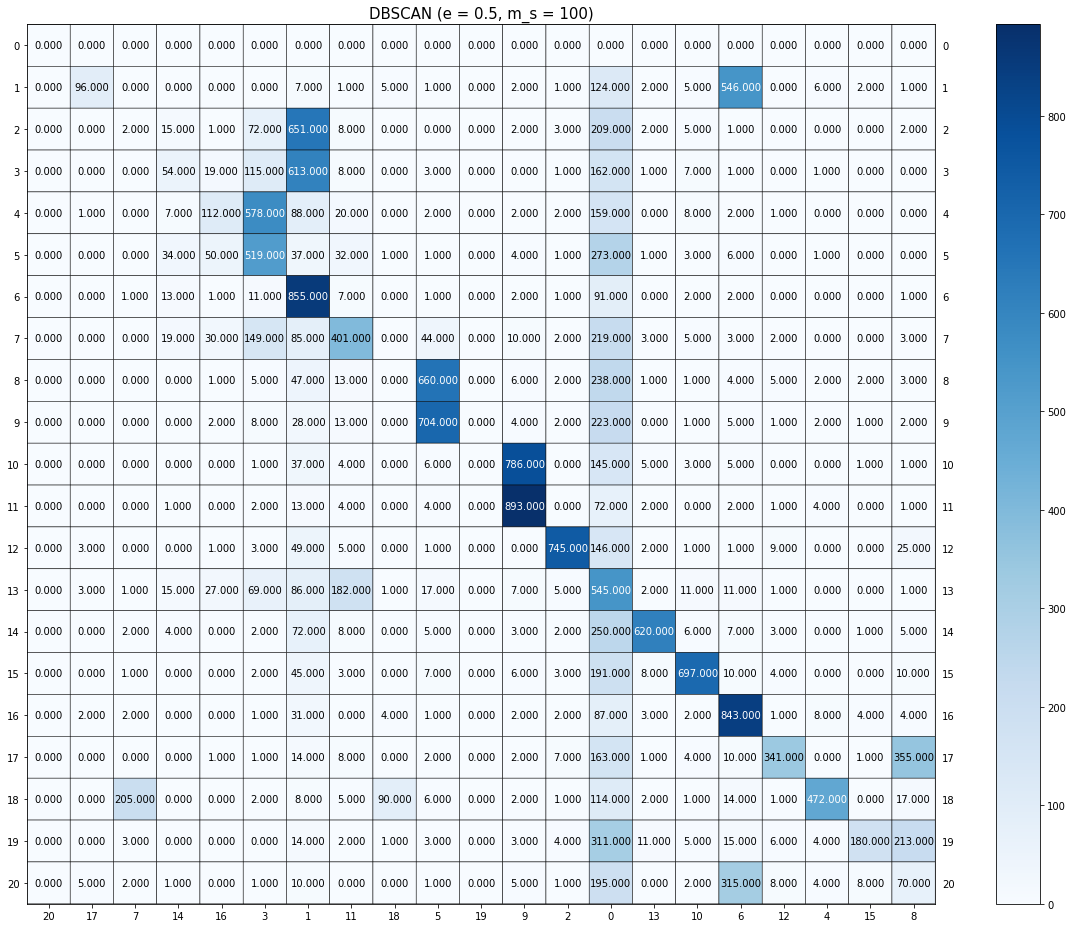

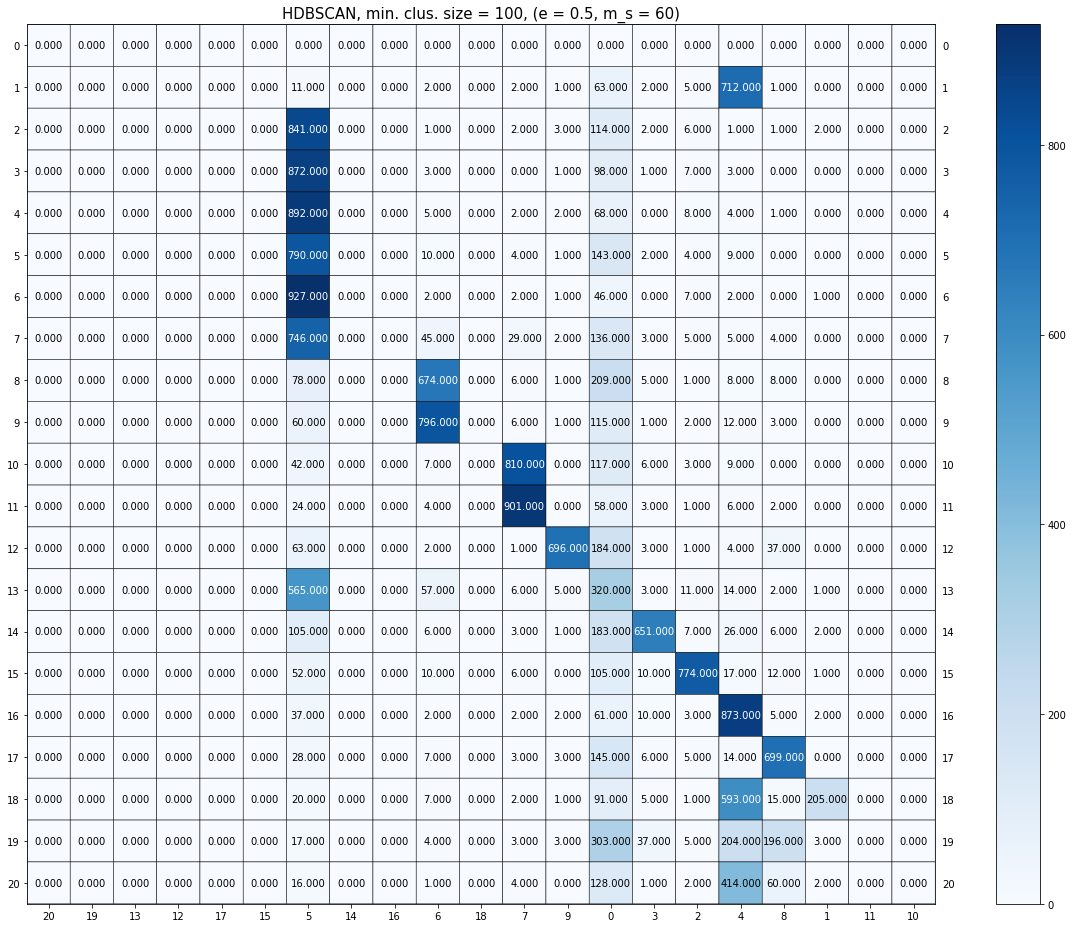

In [27]:
dbs = DBSCAN(eps=best_eps_db,min_samples=best_minSample_db ,n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(dataset.target, dbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'DBSCAN (e = 0.5, m_s = 100)', size=(15,13),pic_fname = 'Q16.1.png')

hdbs = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=best_eps_hdb,min_samples=best_minSample_hdb,core_dist_n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(dataset.target, hdbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'HDBSCAN, min. clus. size = 100, (e = 0.5, m_s = 60)', size=(15,13),pic_fname = 'Q16.2.png')

##Q17

In [ ]:
## grid search of best algorithm and hyper parameters

In [ ]:

score=[]
dimension_red= [
                TruncatedSVD(n_components=5, random_state=0), 
                TruncatedSVD(n_components=20, random_state=0),
                TruncatedSVD(n_components=200, random_state=0),
                NMF(n_components=5, init='random', random_state=0, max_iter=200),
                NMF(n_components=20, init='random', random_state=0, max_iter=200),
                NMF(n_components=200, init='random', random_state=0, max_iter=200),
                umap.UMAP(n_components=5, metric='cosine'),
                umap.UMAP(n_components=20, metric='cosine'),
                umap.UMAP(n_components=200, metric='cosine')
                ]

clustering = [KMeans(n_clusters=10, init='k-means++', max_iter=1000, n_init=30, random_state=0),
              KMeans(n_clusters=20, init='k-means++', max_iter=1000, n_init=30, random_state=0),
              KMeans(n_clusters=50, init='k-means++', max_iter=1000, n_init=30, random_state=0),
              AgglomerativeClustering(n_clusters=20, linkage='ward'),
              DBSCAN(eps=0.5,min_samples=5),
              DBSCAN(eps=0.5,min_samples=15),
              DBSCAN(eps=0.5,min_samples=100),
              DBSCAN(eps=0.5,min_samples=200),
              DBSCAN(eps=5,min_samples=5),
              DBSCAN(eps=5,min_samples=15),
              DBSCAN(eps=5,min_samples=100),
              DBSCAN(eps=5,min_samples=200),
              hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=0.5,min_samples=30),
              hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=0.5,min_samples=5),
              hdbscan.HDBSCAN(min_cluster_size=200,cluster_selection_epsilon=15,min_samples=30),
              hdbscan.HDBSCAN(min_cluster_size=200,cluster_selection_epsilon=15,min_samples=5), 
              hdbscan.HDBSCAN(min_cluster_size=200,cluster_selection_epsilon=20,min_samples=30),
              hdbscan.HDBSCAN(min_cluster_size=200,cluster_selection_epsilon=20,min_samples=5)            
]

for dimension in dimension_red:

  reduced_feat= dimension.fit_transform(data_features)
  

  for cluster in clustering :

    # perform clustering 
    predict_labels= cluster.fit_predict(reduced_feat)
    rand_score = adjusted_rand_score(dataset.target, predict_labels)
    
    print(dimension, cluster, rand_score)
    score.append([dimension, cluster, rand_score])





  

TruncatedSVD(n_components=5, random_state=0) KMeans(max_iter=1000, n_clusters=10, n_init=30, random_state=0) 0.10403424138464548
TruncatedSVD(n_components=5, random_state=0) KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0) 0.1259875510824014
TruncatedSVD(n_components=5, random_state=0) KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0) 0.09845317204936135
TruncatedSVD(n_components=5, random_state=0) AgglomerativeClustering(n_clusters=20) 0.11437723398830446
TruncatedSVD(n_components=5, random_state=0) DBSCAN() 0.0
TruncatedSVD(n_components=5, random_state=0) DBSCAN(min_samples=15) 0.0
TruncatedSVD(n_components=5, random_state=0) DBSCAN(min_samples=100) 0.0
TruncatedSVD(n_components=5, random_state=0) DBSCAN(min_samples=200) 0.0
TruncatedSVD(n_components=5, random_state=0) DBSCAN(eps=5) 0.0
TruncatedSVD(n_components=5, random_state=0) DBSCAN(eps=5, min_samples=15) 0.0
TruncatedSVD(n_components=5, random_state=0) DBSCAN(eps=5, min_samples=100) 0.0
TruncatedSVD

In [ ]:
print(score)

[[TruncatedSVD(n_components=5, random_state=0), KMeans(max_iter=1000, n_clusters=10, n_init=30, random_state=0), 0.10403424138464548], [TruncatedSVD(n_components=5, random_state=0), KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0), 0.1259875510824014], [TruncatedSVD(n_components=5, random_state=0), KMeans(max_iter=1000, n_clusters=50, n_init=30, random_state=0), 0.09845317204936135], [TruncatedSVD(n_components=5, random_state=0), AgglomerativeClustering(n_clusters=20), 0.11437723398830446], [TruncatedSVD(n_components=5, random_state=0), DBSCAN(), 0.0], [TruncatedSVD(n_components=5, random_state=0), DBSCAN(min_samples=15), 0.0], [TruncatedSVD(n_components=5, random_state=0), DBSCAN(min_samples=100), 0.0], [TruncatedSVD(n_components=5, random_state=0), DBSCAN(min_samples=200), 0.0], [TruncatedSVD(n_components=5, random_state=0), DBSCAN(eps=5), 0.0], [TruncatedSVD(n_components=5, random_state=0), DBSCAN(eps=5, min_samples=15), 0.0], [TruncatedSVD(n_components=5, random_stat

In [ ]:

a = np.asarray(score)
results = pd.DataFrame(a)

results.to_csv ('results_17.csv')


In [ ]:
results=results.sort_values(by=[2])[::-1]
results.to_csv ('results_17_sorted.csv')

In [ ]:
results

,0,1,2
127,"UMAP(angular_rp_forest=True, metric='cosine', ...","KMeans(max_iter=1000, n_clusters=20, n_init=30...",0.460283
109,"UMAP(angular_rp_forest=True, metric='cosine', ...","KMeans(max_iter=1000, n_clusters=20, n_init=30...",0.441858
111,"UMAP(angular_rp_forest=True, metric='cosine', ...",AgglomerativeClustering(n_clusters=20),0.438644
129,"UMAP(angular_rp_forest=True, metric='cosine', ...",AgglomerativeClustering(n_clusters=20),0.432165
145,"UMAP(angular_rp_forest=True, metric='cosine', ...","KMeans(max_iter=1000, n_clusters=20, n_init=30...",0.427235
...,...,...,...
153,"UMAP(angular_rp_forest=True, metric='cosine', ...","DBSCAN(eps=5, min_samples=15)",-0.000003
43,"TruncatedSVD(n_components=200, random_state=0)",DBSCAN(min_samples=200),-0.000008
42,"TruncatedSVD(n_components=200, random_state=0)",DBSCAN(min_samples=100),-0.000011
40,"TruncatedSVD(n_components=200, random_state=0)",DBSCAN(),-0.000014


##Q18

In [ ]:
# can you increase the accuracy more

##### these options can be tried for increasing the aaccuracy ##########
# by not removing header and footer
# by using standard scaler
# try stemming or lemmatisation - using pos tag
# try different hyper parameter for 

In [34]:
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

lemmer = WordNetLemmatizer()
def lemmatize_sent(text):
    return [lemmer.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(text))]

In [38]:
lemmatizer = WordNetLemmatizer()
def lemmatized(sentence):
    lemma_list = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
                  for word, tag in pos_tag(word_tokenize(sentence))]
    return lemma_list

In [39]:
dataset = fetch_20newsgroups(subset = 'all',shuffle = True, random_state = 0,remove=('headers','footers'))
vectorizer = CountVectorizer(stop_words='english',min_df=3, analyzer= lemmatized)
tfidf_transformer = TfidfTransformer()
data_features = vectorizer.fit_transform(dataset.data)
data_features = tfidf_transformer.fit_transform(data_features)

In [40]:

score=[]
dimension_red= [
                
                umap.UMAP(n_components=170, metric='cosine'),
                umap.UMAP(n_components=20, metric='cosine'),
                umap.UMAP(n_components=5, metric='cosine'),
                umap.UMAP(n_components=50, metric='cosine')

                ]

clustering = [
              KMeans(n_clusters=20, init='k-means++', max_iter=1000, n_init=30, random_state=0)          
]

for dimension in dimension_red:

  reduced_feat= dimension.fit_transform(data_features)
  

  for cluster in clustering :

    # perform clustering 
    predict_labels= cluster.fit_predict(reduced_feat)
    rand_score = adjusted_rand_score(dataset.target, predict_labels)
    score.append([dimension, cluster, rand_score])
    print(dimension, cluster, rand_score)





  

UMAP(angular_rp_forest=True, metric='cosine', n_components=170, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0) 0.13351688236106035
UMAP(angular_rp_forest=True, metric='cosine', n_components=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0) 0.15244088160608918
UMAP(angular_rp_forest=True, metric='cosine', n_components=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0) 0.15037302842241995
UMAP(angular_rp_forest=True, metric='cosine', n_components=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_f

In [41]:
dataset = fetch_20newsgroups(subset = 'all',shuffle = True, random_state = 0)
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()
data_features = vectorizer.fit_transform(dataset.data)
data_features = tfidf_transformer.fit_transform(data_features)

In [42]:

score=[]
dimension_red= [
                
                
                umap.UMAP(n_components=20, metric='cosine'),
                umap.UMAP(n_components=5, metric='cosine'),
                umap.UMAP(n_components=50, metric='cosine'),
                umap.UMAP(n_components=100, metric='cosine'),

                ]

clustering = [
              KMeans(n_clusters=20, init='k-means++', max_iter=1000, n_init=30, random_state=0)          
]

for dimension in dimension_red:

  reduced_feat= dimension.fit_transform(data_features)
  

  for cluster in clustering :

    # perform clustering 
    predict_labels= cluster.fit_predict(reduced_feat)
    rand_score = adjusted_rand_score(dataset.target, predict_labels)
    score.append([dimension, cluster, rand_score])
    print(dimension, cluster, rand_score)





  

UMAP(angular_rp_forest=True, metric='cosine', n_components=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0) 0.413360349873704
UMAP(angular_rp_forest=True, metric='cosine', n_components=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0) 0.38480569479008614
UMAP(angular_rp_forest=True, metric='cosine', n_components=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}) KMeans(max_iter=1000, n_clusters=20, n_init=30, random_state=0) 0.3835397468562175
UMAP(angular_rp_forest=True, metric='cosine', n_components=100, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt}